In [0]:
!pip install html2text #ONLY if html2text not installed

In [0]:
import numpy as np
import pandas as pd
from __future__ import print_function
import sys
import io
import random

# NLP and text
from html2text import html2text
import re
import string
import nltk
from nltk.data import find
import gensim
from gensim.models import Word2Vec
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Machine learning
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load ascii text and covert to lowercase
filename = "/content/drive/My Drive/Unsupervised Project/all_djt_tweets.csv"
df = pd.read_csv(filename, header=0)
df['text']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0         Over 90% approval rating for your all time fav...
1         “Mainstream Media tries to rewrite history to ...
2         Fantastic numbers on consumer spending release...
3         ...And it will get, as I have always said, muc...
4         RT @realDonaldTrump: Social Media Giants are s...
                                ...                        
328048    "My persona will never be that of a wallflower...
328049    New Blog Post: Celebrity Apprentice Finale and...
328050    Donald Trump reads Top Ten Financial Tips on L...
328051    Donald Trump will be appearing on The View tom...
328052    Be sure to tune in and watch Donald Trump on L...
Name: text, Length: 328053, dtype: object

Since this data is generated from YouTube subtitles, we would want to get rid of things like special characters

Src: https://www.kaggle.com/binksbiz/sentiment-analysis

In [0]:
df.loc[df['text'] == None]

,Unnamed: 0,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str


In [0]:
# cleanup
alphabet = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'
def cleanup(sentence):

    if(isinstance(sentence, float)):
      return ''

    output = html2text(sentence) 
    # remove retweets and mentions
    output = re.sub("^RT @.*", "", output)

    output = re.sub("^@.*", "", output)
    
    output = output.lower()
    # remove hashtags
    output = re.sub("#\w+$", "", output)
    # remove urls
    urlregex = "https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}"
    output = re.sub(urlregex, "", output)
    
    # remove special characters 
    output = re.sub("[…“\"”&+,:;=?#$|<>.^*()!–_]", "", output)

    output = re.sub("-", " ", output)
    output = ''.join(filter(lambda x: x in alphabet, output))
    
    # remove twitter handles 
    output = re.sub("@[a-zA-Z0-9]+", " <@twitter_handle> ", output)
    
    # remove numbers and percentages
    output = re.sub("(\d+%)\s+|\s+(\d+%)", " <percentage> ", output)
    output = re.sub("(\d+)\s+|\s+(\d+)", " <number> ", output)

    # remove extra spaces
    output = re.sub("\s+", " ", output).strip()
    # if(output == 'nan'):
    #   print(sentence)
    return  output + ' <eot>' if len(output) > 0 else ''


df['clean_tweets'] = df['text'].apply(cleanup)


In [0]:
len(df['clean_tweets'])

328053

In [0]:
clean_tweets = df.loc[df['clean_tweets'] != '']

In [0]:
clean_tweets = clean_tweets.astype(str)['clean_tweets']

In [0]:
len(clean_tweets)

32536

In [0]:
tweets = clean_tweets.astype(str).tolist()

In [0]:
all_tweets = ' '.join(tweets)
corpus = all_tweets
len(all_tweets)

3887319

In [0]:
# nltk.download('word2vec_sample')
# word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
# embedding = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [0]:
# AVERAGE WORD COUNT IN TWEETS 
all_sentences = []
lengths = []
for tweet in tweets:
  lengths.append(len(tweet))
  sentence = tweet.split(' ')
  all_sentences.append(sentence)

np.array(lengths).mean()

118.47750184411113

In [0]:
embedding = Word2Vec(all_sentences,  size=100, min_count=1)  # word_model=gensim.models.Word2Vec(sentences, size=200, min_count=1, window=5)

In [0]:
embdim = embedding.wv['the'].size


In [0]:
words = corpus.split(' ')

In [0]:
# https://keras.io/examples/lstm_text_generation/
# cut the text in semi-redundant sequences of seqlen words
seqlen = 20
step = 5
sentences = []
next_word = []
for i in range(0, len(words) - seqlen, step):
    sentences.append(words[i: i + seqlen])
    next_word.append(words[i + seqlen])

In [0]:
sentences[0][:100]

['over',
 '<percentage>',
 'approval',
 'rating',
 'for',
 'your',
 'all',
 'time',
 'favorite',
 'i',
 'hope',
 'president',
 'within',
 'the',
 'republican',
 'party',
 'and',
 '<percentage>',
 'overall',
 'this']

In [0]:
print('nb sequences:', len(sentences))
print('Vectorization...')
x = np.zeros((len(sentences), seqlen, embdim))
y = np.zeros((len(sentences), embdim))

for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t,:] = embedding.wv[word]

for i, next_word in enumerate(next_word):
    y[i, :] = embedding.wv[next_word]

nb sequences: 122219
Vectorization...


In [0]:
x.shape

(122219, 20, 100)

In [0]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
# model.add(CuDNNLSTM(128, return_sequences=True, input_shape=(seqlen, embdim)))
# model.add(Dropout(0.2))
model.add(CuDNNLSTM(250))
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu'))
model.add(Dense(embdim, activation='linear'))

optimizer = Adam(lr=0.01, decay=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])


def sample(similars, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = [elt[1] for elt in similars]

    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    argm = np.argmax(probas)
    return similars[argm][0]

def vec2word(vec, temperature=1.0):
    similars = embedding.most_similar(positive=[vec], topn=10)
    return sample(similars, temperature)

def arr2sent(arr):
    return TreebankWordDetokenizer().detokenize(arr)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(all_sentences))
    sentence = all_sentences[start_index][0:10]
    print(sentence)
    generated = sentence
    
    print('----- Generating with seed: "' + arr2sent(sentence) + '"')
    for i in range(50):
        x_pred = np.zeros((1, seqlen, embdim))
        for t, word in enumerate(sentence):
            x_pred[0, t, :] = embedding.wv[word]

        vec = model.predict(x_pred, verbose=0)[0]
        next_word = vec2word(vec, 0.5)

        sentence.append(next_word)
        sentence = sentence[1:]
        generated.append(next_word)
    print(arr2sent(generated))

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

#batch_size=128
history = model.fit(x, y,
          batch_size=200, 
          epochs=120,
          callbacks=[print_callback])

Build model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Epoch 1/120





122219/122219 [==============================] - 13s 105us/step - loss: 0.2982 - acc: 0.3543

----- Generating text after Epoch: 0
['<@twitter_handle>', '<@twitter_handle>', '<@twitter_handle>', 'trump', 'thedonald', '<number>', 'm', 'followers', 'ck', 'the']
----- Generating with seed: "<@twitter_handle> <@twitter_handle> <@twitter_handle> trump thedonald <number> m followers ck the"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<@twitter_handle> <@twitter_handle> <@twitter_handle> trump thedonald <number> m followers ck the sensational sensational wearethepeople montana magnet begin return begin happen <eot> tgdn be return leave end continue stay otherwise approved slowly yours <eot> tgdn end continue continue end return determine reciprocal recognition rich magnet kellyanne grow otherwise sensational otherwise <eot> journalist continue lose start fight end end stay begin continue stay otherwise
Epoch 2/120
122219/122219 [==============================] - 5s 44us/step - loss: 0.2847 - acc: 0.3707

----- Generating text after Epoch: 1
['i', 'told', 'you', 'so', 'a', 'long', 'time', 'ago', 'iraq', 'just']
----- Generating with seed: "i told you so a long time ago iraq just"
i told you so a long time ago iraq just respectedonce respectedonce picking carmel barrels sensational bounds <eot> otherwise determine determine slowly <eot> slowly slowly seldom see utmost slowly respectedonce nebraska bounds sensational <

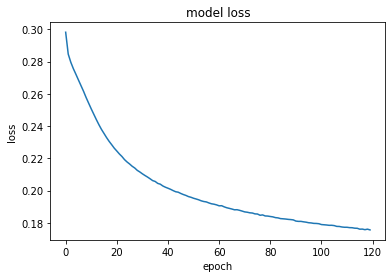

In [0]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()